In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt 
device = torch.device("cuda:0")


In [2]:
with open("datasets/tinyShakespeare.txt", "r") as f:
    load = f.read()
print(load[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


In [3]:
texttoint = {elm: n for n, elm in enumerate(set(load))}
inttotext = {n:elm for n, elm in enumerate(set(load))}
dataset = [texttoint[c] for c in load]

vocab_size = len(texttoint)
sequence_length = 20

sequences = torch.tensor([dataset[i:-sequence_length+i-1] for i in range(sequence_length+1)]).T
inputs = sequences[2000:, :-1]
labels = sequences[2000:, -1]
val_inputs = sequences[:2000, :-1]
val_labels = sequences[:2000, -1]

# Attention Block - Scaled dot product attention

A very effective system that can find correlations between tokens is the attention block <br><br>

It takes in a series of tokens: input (sequence_length, embedding_size)<br>
we call this layer "attention head", you can have one head of self attention or many heads with different weights. <br> 
and computes the dot products with 3 sets of weights, called "keys", "queries" and "values" of size (emb_size, head_size) <br>
 
After this operation you have three tensors of size (sequence_length, head_size) <br>
you compute the similarity matrix (sequence_length, sequence_length) by multiplying keys with transposed queries. <br><br>

The next step is to tril (transform to lower triangular) and softmax the similarity matrix, and a scaling by sqrt(head_size) <br>
(This is why its called scaled dot product attention) <br>
Following is a dot product with the values. The output will be (sequence_length, head_size) <br>

This block has roughly a complexity of O(sequence_length^2) witch is sub optimal for long sequence lengths, so we use sligthly different attention blocks for that<br>

In [5]:
class Attention(nn.Module):  # This is the masked attention module
    def __init__(self, emb_size=10, head_size=128):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size)

    def forward(self, x):
        # attention
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        similarity = torch.tril(similarity)
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        
        attention = similarity @ v 
        return attention


class FullyConnected(nn.Module):  # This is basically what we had before, the simple MLP without residual connections
    def __init__(self, in_size=10, hidden_size=128, out_size=vocab_size, n_layers=2):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = F.gelu(fc(x))
        return self.fc2(x)


class Block(nn.Module):  # This is the block that we will use in the transformer
    def __init__(self):
        super().__init__()
        emb_size = 10
        self.head_size = head_size = 128

        self.embeddings = nn.Embedding(vocab_size, emb_size)
        self.att = Attention(emb_size, head_size).to(device)
        self.fc = FullyConnected(head_size).to(device)

    def forward(self, x):  # inputs: [Batch_size, time, vocab_size]
        batch_size = x.shape[0]
        
        x = self.embeddings(x)
        x = self.att(x) 
        x = x.view(batch_size, sequence_length*self.head_size)
        x = self.fc(x)

        return x

device = torch.device("cuda:0")
model = Block().to(device)

epochs = 10000
batch_size = 8192
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())
    
    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

4.181812763214111
1.7210773229599
1.6213728189468384
1.5663319826126099
1.5551037788391113
1.5286071300506592
1.5103294849395752
1.4697332382202148
1.4472392797470093
1.493862509727478


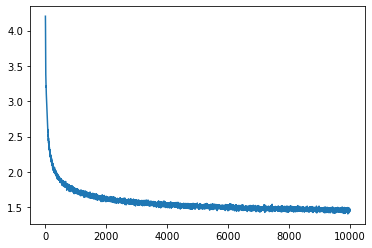

In [ ]:
plt.plot(lossi[:]) # 1.45

In [6]:
string = "           \nKING RICHARD I"
print(string, end="")

with torch.no_grad():
    for _ in range(300):
        X = torch.tensor([texttoint[s] for s in string[-sequence_length:]]).long().view(1, -1).to(device)
        pred = model.forward(X)
        string += inttotext[torch.multinomial(F.softmax(pred, dim=1), 1).item()]
        print(string[-1], end="")


           
KING RICHARD II:
Then wwence thee,
Suburrigny: forge of lamour
When answer. Chrisby:
I, the mean
anch you have sends of Ballow.

SAMPSON:
What my heavy she gring, so, see
Would for laboursess seeds that we wash?

PETER:
As I be a richmen:
Or all himself an one service in torbour wish all theset's gracioe't?
Edwar

# Transformers 

Transformers consist of attention blocks in sequence, with residual connections 

In [8]:
class Attention(nn.Module):  
    def __init__(self, emb_size=10, head_size=128):
        super(Attention, self).__init__()
        self.head_size = head_size

        self.keys = nn.Linear(emb_size, head_size)
        self.queries = nn.Linear(emb_size, head_size)
        self.values = nn.Linear(emb_size, head_size)

    def forward(self, x):
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        similarity = torch.tril(similarity)
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        
        attention = similarity @ v 
        return attention


class FullyConnected(nn.Module):  
    def __init__(self, in_size=10, hidden_size=128, out_size=sequence_length*10, n_layers=2):
        super(FullyConnected, self).__init__()

        self.fc1 = nn.Linear(in_size*sequence_length, hidden_size)
        self.fcx = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(n_layers)])
        self.fc2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        for fc in self.fcx:
            x = x + F.gelu(fc(x)) # Residual connection not present in the original paper, but it helps with convergence
        return self.fc2(x)


class Block(nn.Module): 
    def __init__(self, emb_size):
        super().__init__()
        self.head_size = head_size = 128

        self.att = Attention(emb_size, head_size).to(device)
        self.fc = FullyConnected(head_size, emb_size*sequence_length).to(device)

    def forward(self, x):  
        batch_size = x.shape[0]
        
        x = self.att(x) 
        x = x.view(batch_size, sequence_length*self.head_size)
        x = self.fc(x)

        return x

# Everything is the same upto here. Now we will create a transformer class that combines the blocks
class Transformer(nn.Module): 
    def __init__(self, n_blocks=2):
        super().__init__()
        emb_size = 10

        self.embs = nn.Embedding(vocab_size, emb_size) 
        self.blocks = nn.ModuleList([Block(emb_size) for _ in range(n_blocks)])
        self.LinOut = nn.Linear(emb_size*sequence_length, vocab_size)

    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.embs(x)
        for block in self.blocks:
            x = x + block(x).view(-1, x.shape[1], x.shape[2])
        x = self.LinOut(x.view(batch_size, -1))
        return x

device = torch.device("cuda:0")
model = Transformer().to(device)

epochs = 10000
batch_size = 8192
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4) 

lossi = []
vlossi = []

for epoch in range(epochs):
    indexes = torch.randint(0, len(inputs), (batch_size,))
    
    pred = model(inputs[indexes].to(device)) # everything in the forward pass happens in the model class
    loss = F.cross_entropy(pred, labels[indexes].to(device))

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    lossi.append(loss.item())
    if epoch % (epochs//10) == 0:
        print(loss.item())

    with torch.no_grad():
        pred = model(val_inputs.to(device))
        loss = F.cross_entropy(pred, val_labels.to(device))
        vlossi.append(loss.item())

4.312550067901611
1.6860811710357666
1.562029242515564
1.4947874546051025
1.460423469543457
1.4215669631958008
1.3750406503677368
1.3662678003311157
1.4118024110794067
1.3118298053741455


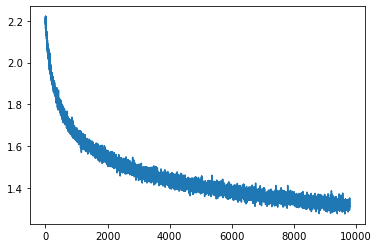

In [9]:
plt.plot(lossi[200:])

# Results
As you can see we can get really good loss with the transformer, this architecture scales well up to GPT3.5 level performance with enough high quality data

In [10]:
print("Millions of parameters: ", round(sum(p.numel() for p in model.parameters() if p.requires_grad)/1000000, 2))
print([p.numel() for p in model.parameters() if p.requires_grad])

Millions of parameters:  1.29
[650, 1280, 128, 1280, 128, 1280, 128, 512000, 200, 40000, 200, 40000, 200, 40000, 200, 1280, 128, 1280, 128, 1280, 128, 512000, 200, 40000, 200, 40000, 200, 40000, 200, 13000, 65]


# MoE
The way these models encode information is in their weights, but you dont always need to compute all of the weights to get to the next token, for example if there is an area of weights that mostly encode the names of cities, you dont need them when the next token is the solution of a quadratic equation. <br>
So it stands to reason that you could have many sets of weights that the model can choose to use in real time to get more efficient inference. For instance the mistral Mixture of Experts model uses 8 sets of 7B weights, and at any point in time only 13B parameters are used. Thats a 3-4x speedup over a similar model without MoE with marginal impact on performance. GPT-4 is also based on MoE of 16 x 110B models  